# Debunking the Phillips Curve

The Phillips curve is a single-equation econometric model, named after William Phillips, describing a historical inverse relationship between rates of unemployment and corresponding rates of rises in wages that result within an economy. Stated simply, decreased unemployment, (i.e., increased levels of employment) in an economy will correlate with higher rates of wage rises. Phillips did not himself state there was any relationship between employment and inflation, this notion was a trivial deduction from his statistical findings. 

While there is a short run tradeoff between unemployment and inflation, it has not been observed in the long run. In 1967 and 1968, Milton Friedman and Edmund Phelps asserted that the Phillips curve was only applicable in the short-run and that in the long-run, inflationary policies would not decrease unemployment. Friedman then correctly predicted that in the 1973–75 recession, both inflation and unemployment would increase. The long-run Phillips curve is now seen as a vertical line at the natural rate of unemployment, where the rate of inflation has no effect on unemployment. In recent years the slope of the Phillips curve appears to have declined and there has been significant questioning of the usefulness of the Phillips curve in predicting inflation. Nonetheless, the Phillips curve remains the primary framework for understanding and forecasting inflation used in central banks.

**US Phillips Curve: Inflation vs Unemployment**

Y axis: Inflation %

X axis: Unemployment %

Phillips Curve describes historical inverse relationship between 
rates of unemployment and corresponding rates of rises in wages that
result within an economy. 

Decreased unemployment will correlate with higher rates of wages rises. 

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import RANSACRegressor

# Data Import/Processing

In [175]:
# Loading our data.
## US Unemployment Rate, seasonally-adjusted.
unrate = pd.read_csv('~/src/data/fredData/unrate.csv')

## Consumer Price Index for All Urban Consumers: All Items.
cpiaucsl = pd.read_csv('~/src/data/fredData/cpiaucsl.csv')

In [176]:
unrate.head(10)

,UNRATE,Unnamed: 1
0,lin,Percent
1,M,Monthly
2,01/01/1948,1948-01-01 to 2019-03-01
3,Civilian Unemployment Rate,NaN
4,U.S. Bureau of Labor Statistics,NaN
5,date,value
6,01/01/1948,3.4
7,02/01/1948,3.8
8,03/01/1948,4.0
9,04/01/1948,3.9


In [177]:
cpiaucsl.head(10)

,CPIAUCSL,Unnamed: 1,Unnamed: 2
0,lin,Index 1982-1984=100,NaN
1,M,Monthly,NaN
2,1/1/1947,1947-01-01 to 2019-03-01,NaN
3,Consumer Price Index for All Urban Consumers: ...,NaN,NaN
4,U.S. Bureau of Labor Statistics,NaN,NaN
5,date,value,cpi_rate
6,1/1/1947,21.5,NaN
7,2/1/1947,21.6,0.0047
8,3/1/1947,22,0.0185
9,4/1/1947,22,0.0000


In [178]:
# General function for cleaining raw FRED datasets.
def process_fredData(df, oldCol1, newCol1, oldCol2, newCol2):
    # Removes the FRED plug-in parameters.
    new_df = df.drop([0, 1, 2, 3, 4, 5])
    # Resetting index.
    new_df = new_df.reset_index(drop=True)
    # Renaming columns.
    new_df = new_df.rename(columns={oldCol1: newCol1, oldCol2: newCol2})
    return new_df

In [179]:
df_unrate = process_fredData(unrate, "UNRATE", "date", "Unnamed: 1", "unrate")
df_cpi = process_fredData(cpiaucsl, "CPIAUCSL", "date", "Unnamed: 1", "cpi_val")

In [180]:
df_unrate.head()

,date,unrate
0,01/01/1948,3.4
1,02/01/1948,3.8
2,03/01/1948,4.0
3,04/01/1948,3.9
4,05/01/1948,3.5


In [181]:
df_unrate['unrate'] = pd.to_numeric(df_unrate.unrate, errors='coerce')
print(df_unrate.dtypes)
df_unrate.head()

date       object
unrate    float64
dtype: object


,date,unrate
0,01/01/1948,3.4
1,02/01/1948,3.8
2,03/01/1948,4.0
3,04/01/1948,3.9
4,05/01/1948,3.5


In [182]:
df_cpi.head()

,date,cpi_val,Unnamed: 2
0,1/1/1947,21.5,NaN
1,2/1/1947,21.6,0.0047
2,3/1/1947,22,0.0185
3,4/1/1947,22,0.0000
4,5/1/1947,22,0.0000


In [183]:
df_cpi = df_cpi.rename(columns={"date": "cpi_dates", "Unnamed: 2": "cpi"})
df_cpi.head(15)

,cpi_dates,cpi_val,cpi
0,1/1/1947,21.5,NaN
1,2/1/1947,21.6,0.0047
2,3/1/1947,22,0.0185
3,4/1/1947,22,0.0000
4,5/1/1947,22,0.0000
5,6/1/1947,22.1,0.0045
6,7/1/1947,22.2,0.0045
7,8/1/1947,22.4,0.0090
8,9/1/1947,22.8,0.0179
9,10/1/1947,22.9,0.0044


In [184]:
# Trimming df_cpi to match starting dates.
df_cpi = df_cpi.drop([0,1,2,3,4,5,6,7,8,9,10,11])
df_cpi = df_cpi.reset_index(drop=True)
df_cpi.head()

,cpi_dates,cpi_val,cpi
0,1/1/1948,23.7,0.0128
1,2/1/1948,23.7,0.0000
2,3/1/1948,23.5,-0.0084
3,4/1/1948,23.8,0.0128
4,5/1/1948,24,0.0084


In [185]:
df_cpi.dtypes

cpi_dates    object
cpi_val      object
cpi          object
dtype: object

In [186]:
df_cpi['cpi'] = pd.to_numeric(df_cpi.cpi, errors='coerce')
df_cpi['cpi_val'] = pd.to_numeric(df_cpi.cpi_val, errors='coerce')
print(df_cpi.dtypes)
df_cpi.head()

cpi_dates     object
cpi_val      float64
cpi          float64
dtype: object


,cpi_dates,cpi_val,cpi
0,1/1/1948,23.7,0.0128
1,2/1/1948,23.7,0.0000
2,3/1/1948,23.5,-0.0084
3,4/1/1948,23.8,0.0128
4,5/1/1948,24.0,0.0084


In [187]:
print(len(df_unrate))
print(len(df_cpi))

855
855


In [188]:
df = pd.concat([df_unrate, df_cpi], axis=1)
df.head(15)

,date,unrate,cpi_dates,cpi_val,cpi
0,01/01/1948,3.4,1/1/1948,23.7,0.0128
1,02/01/1948,3.8,2/1/1948,23.7,0.0000
2,03/01/1948,4.0,3/1/1948,23.5,-0.0084
3,04/01/1948,3.9,4/1/1948,23.8,0.0128
4,05/01/1948,3.5,5/1/1948,24.0,0.0084
5,06/01/1948,3.6,6/1/1948,24.2,0.0083
6,07/01/1948,3.6,7/1/1948,24.4,0.0083
7,08/01/1948,3.9,8/1/1948,24.4,0.0000
8,09/01/1948,3.8,9/1/1948,24.4,0.0000
9,10/01/1948,3.7,10/1/1948,24.3,-0.0041


In [189]:
df = df.drop(['cpi_dates'], axis=1)
df.head()

,date,unrate,cpi_val,cpi
0,01/01/1948,3.4,23.7,0.0128
1,02/01/1948,3.8,23.7,0.0000
2,03/01/1948,4.0,23.5,-0.0084
3,04/01/1948,3.9,23.8,0.0128
4,05/01/1948,3.5,24.0,0.0084


In [190]:
# Creating date-based index.
df.index = pd.to_datetime(df.date)
df.head()

,date,unrate,cpi_val,cpi
date,,,,
1948-01-01,01/01/1948,3.4,23.7,0.0128
1948-02-01,02/01/1948,3.8,23.7,0.0000
1948-03-01,03/01/1948,4.0,23.5,-0.0084
1948-04-01,04/01/1948,3.9,23.8,0.0128
1948-05-01,05/01/1948,3.5,24.0,0.0084


# Visualizing

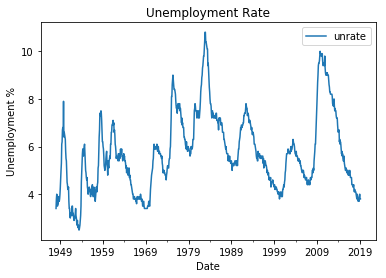

In [191]:
df[['unrate']].plot()
plt.title('Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Unemployment %')
plt.show()

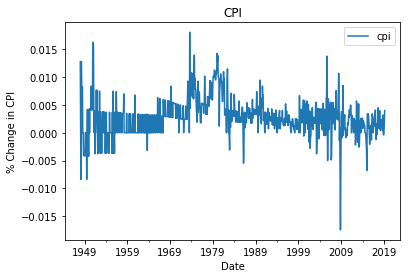

In [192]:
df[['cpi']].plot()
plt.title('CPI')
plt.xlabel('Date')
plt.ylabel('% Change in CPI')
plt.show()

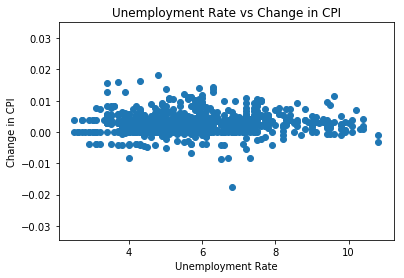

In [193]:
plt.scatter(x=df.unrate, y=df.cpi)
plt.xlabel('Unemployment Rate')
plt.ylabel('Change in CPI')
plt.title('Unemployment Rate vs Change in CPI')
plt.show()

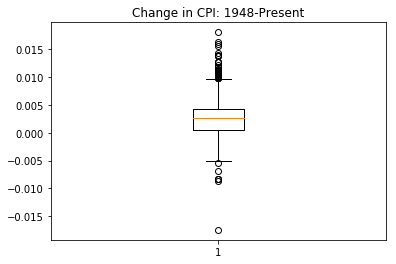

In [194]:
plt.boxplot([df.cpi])
plt.title('Change in CPI: 1948-Present')
plt.show()

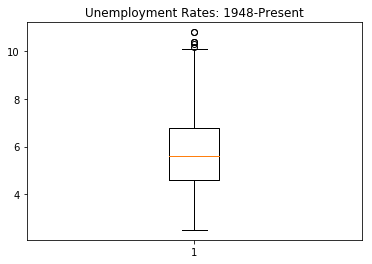

In [195]:
plt.boxplot([df.unrate])
plt.title('Unemployment Rates: 1948-Present')
plt.show()

In [196]:
df.head()

,date,unrate,cpi_val,cpi
date,,,,
1948-01-01,01/01/1948,3.4,23.7,0.0128
1948-02-01,02/01/1948,3.8,23.7,0.0000
1948-03-01,03/01/1948,4.0,23.5,-0.0084
1948-04-01,04/01/1948,3.9,23.8,0.0128
1948-05-01,05/01/1948,3.5,24.0,0.0084


In [197]:
df.describe()

,unrate,cpi_val,cpi
count,855.000000,855.000000,855.000000
mean,5.756374,109.798830,0.002799
std,1.639387,76.519647,0.003389
min,2.500000,23.500000,-0.017500
25%,4.600000,31.750000,0.000500
50%,5.600000,100.100000,0.002700
75%,6.800000,177.350000,0.004200
max,10.800000,254.100000,0.018100


# Regression Modeling

In [198]:
# Assign X & Y.
X = pd.DataFrame(df.unrate)
Y = list(df.cpi)
print(len(X))
print(len(Y))

855
855


In [199]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

lm.fit(X, Y)
print('coefficients: ' + str(lm.coef_))
print('intercept: ' + str(lm.intercept_))
print('score: ' + str(lm.score(X,Y)))

coefficients: [7.86594828e-05]
intercept: 0.0023463878638789733
score: 0.0014476026803427189


In [200]:
from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

hr.fit(X,Y)
print('coefficients: ' + str(hr.coef_))
print('intercept: ' + str(hr.intercept_))
print('score: ' + str(hr.score(X,Y)))

coefficients: [9.38238158e-05]
intercept: 0.0019763772685483425
score: -0.005572501001204655


In [201]:
robust = [hr.coef_[0] * i + hr.intercept_ for i in range(-6, 10)]
linear = [lm.coef_[0] * i + lm.intercept_ for i in range(-6, 10)]

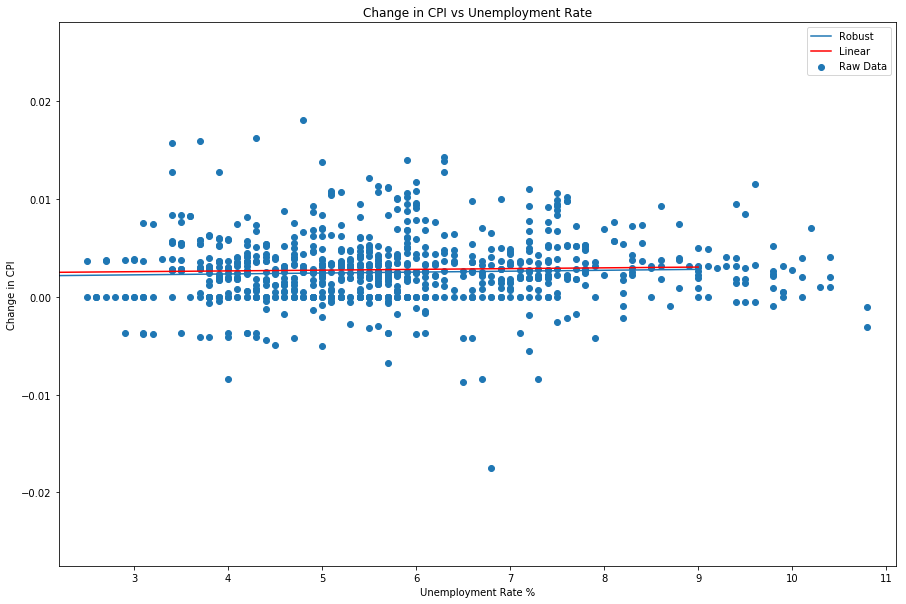

In [202]:
plt.rcParams['figure.figsize'] = (15, 10)

plt.scatter(x=df.unrate, y=df.cpi, label='Raw Data')

plt.plot(range(-6,10), robust, label='Robust')
plt.plot(range(-6,10), linear, 'r', label='Linear')
plt.legend()
plt.title('Change in CPI vs Unemployment Rate')
plt.xlabel('Unemployment Rate %')
plt.ylabel('Change in CPI')

xmin = min(df.unrate)
ymin = min(df.cpi)
xmax = max(df.unrate)
ymax = max(df.cpi)

plt.xlim(xmin - 0.3, xmax + 0.3)
plt.ylim(ymin - 0.01, ymax + 0.01)

plt.show()

No clear linear relationship between 1948 and 2019. We can change our time period for the data to look over the short-run, as did Friedman and Phelps in 1967, whom asserted that the Phillips curve was only applicable over the short-term.

# Thiel-Sen and RANSAC Robust Regressors

PROBIT regressor not applicable as it is form of logistic regression.

TOBIT regressor is linear regression, but we do want to include our negative values ie: negative % change in CPI.

In [203]:
from sklearn.linear_model import TheilSenRegressor
ts = TheilSenRegressor()

ts.fit(X, Y)

print('coefficients: ' + str(ts.coef_))
print('intercept: ' + str(ts.intercept_))
print('score: ' + str(ts.score(X,Y)))

coefficients: [0.00014509]
intercept: 0.0018962303762151782
score: 1.4832076634108125e-05


In [204]:
robust = [ts.coef_[0] * i + ts.intercept_ for i in range(-6, 10)]
linear = [lm.coef_[0] * i + lm.intercept_ for i in range(-6, 10)]

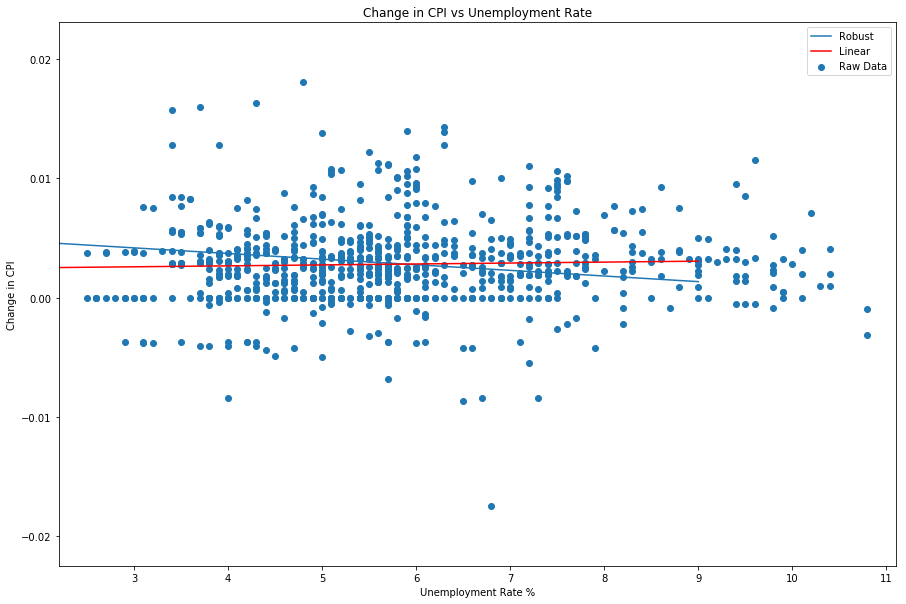

In [211]:
plt.rcParams['figure.figsize'] = (15, 10)

plt.scatter(x=df.unrate, y=df.cpi, label='Raw Data')

plt.plot(range(-6,10), robust, label='Robust')
plt.plot(range(-6,10), linear, 'r', label='Linear')
plt.legend()
plt.title('Change in CPI vs Unemployment Rate')
plt.xlabel('Unemployment Rate %')
plt.ylabel('Change in CPI')

xmin = min(df.unrate)
ymin = min(df.cpi)
xmax = max(df.unrate)
ymax = max(df.cpi)

plt.xlim(xmin - 0.3, xmax + 0.3)
plt.ylim(ymin - 0.005, ymax + 0.005)

plt.show()

In [206]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor()

ransac.fit(X, Y)

#print('coefficients: ' + str(ransac.coef_))
#print('intercept: ' + str(ransac.intercept_))

print('coefficients: ' + str(ransac.estimator_.coef_))
print('intercept: ' + str(ransac.estimator_.intercept_))
print('score: ' + str(ransac.score(X,Y)))

coefficients: [-0.00047205]
intercept: 0.00558670651667988
score: -0.06993829701572674


In [207]:
robust = [ransac.estimator_.coef_[0] * i + ransac.estimator_.intercept_ for i in range(-6, 10)]
linear = [lm.coef_[0] * i + lm.intercept_ for i in range(-6, 10)]

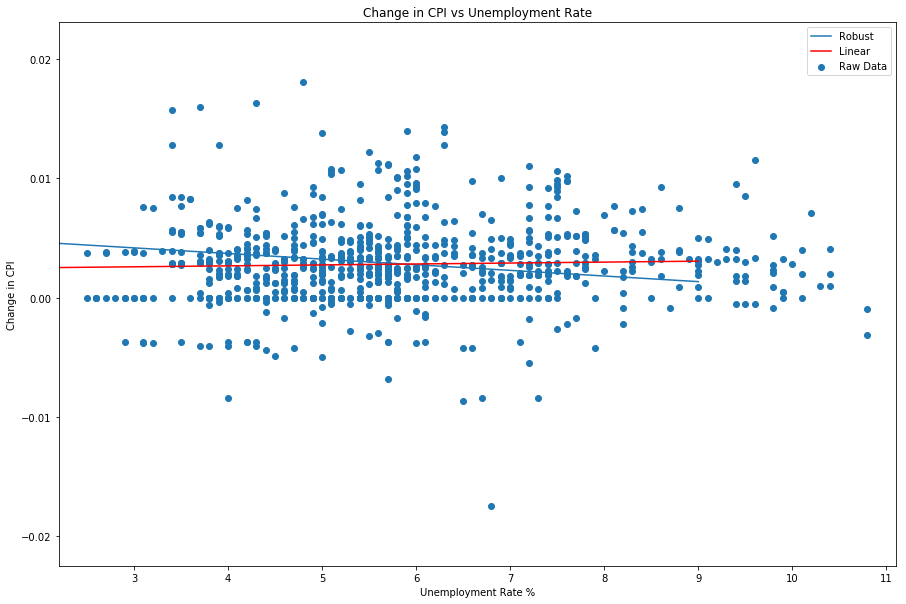

In [212]:
plt.rcParams['figure.figsize'] = (15, 10)

plt.scatter(x=df.unrate, y=df.cpi, label='Raw Data')

plt.plot(range(-6,10), robust, label='Robust')
plt.plot(range(-6,10), linear, 'r', label='Linear')
plt.legend()
plt.title('Change in CPI vs Unemployment Rate')
plt.xlabel('Unemployment Rate %')
plt.ylabel('Change in CPI')

xmin = min(df.unrate)
ymin = min(df.cpi)
xmax = max(df.unrate)
ymax = max(df.cpi)

plt.xlim(xmin - 0.3, xmax + 0.3)
plt.ylim(ymin - 0.005, ymax + 0.005)

plt.show()